<a href="https://colab.research.google.com/github/vivekvardhan30/NNFL-Project/blob/main/Genetic_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#import libraries
import numpy as np
import pandas as pd
import tensorflow as tf

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, log_loss
from tabulate import tabulate
import matplotlib.pyplot as plt

# === Load and Prepare Data ===
df = pd.read_csv("heart_disease_risk_dataset_earlymed.csv")
X = df.drop("Heart_Risk", axis=1).values
y = df["Heart_Risk"].astype(int).values.reshape(-1, 1)

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_small = X_train[:100]
y_train_small = y_train[:100]

# === Define the model ===
def build_model():
    model = Sequential()
    model.add(Dense(32, input_dim=X.shape[1], activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

# === Genetic Algorithm ===
class GeneticAlgorithm:
    def __init__(self, obj_func, lb, ub, dim, pop_size=6, max_iters=50):
        self.obj_func = obj_func
        self.lb = np.array([lb] * dim)
        self.ub = np.array([ub] * dim)
        self.dim = dim
        self.n = pop_size
        self.max_iters = max_iters
        self.acc_progress = []
        self.loss_progress = []

    def optimize(self):
        population = np.random.uniform(self.lb, self.ub, (self.n, self.dim))
        fitness = np.array([self.obj_func(ind) for ind in population])
        best_idx = np.argmin(fitness)
        best_sol = {"Position": population[best_idx], "Cost": fitness[best_idx]}

        for _ in range(self.max_iters):
            idx = np.argsort(fitness)
            parents = population[idx[:2]]
            children = []

            for _ in range(self.n - 2):
                p1, p2 = parents[np.random.choice(2, 2)]
                alpha = np.random.rand()
                child = alpha * p1 + (1 - alpha) * p2
                mutation = np.random.randn(self.dim) * 0.01
                child = np.clip(child + mutation, self.lb, self.ub)
                children.append(child)

            population = np.vstack((parents, children))
            fitness = np.array([self.obj_func(ind) for ind in population])
            best_idx = np.argmin(fitness)
            if fitness[best_idx] < best_sol["Cost"]:
                best_sol = {"Position": population[best_idx], "Cost": fitness[best_idx]}

            # === Track accuracy/loss on test set ===
            best_weights = population[best_idx]
            ga_model.set_weights(reshape_weights(best_weights))
            y_pred = ga_model.predict(X_test, verbose=0)
            acc = accuracy_score(y_test, (y_pred > 0.5).astype(int))
            loss = log_loss(y_test, y_pred)
            self.acc_progress.append(acc)
            self.loss_progress.append(loss)

        return best_sol

# === Setup for GA ===
ga_model = build_model()
initial_weights = np.concatenate([w.flatten() for w in ga_model.get_weights()])
model_shape = [w.shape for w in ga_model.get_weights()]
dim = len(initial_weights)

def reshape_weights(flat_weights):
    new_weights = []
    idx = 0
    for shape in model_shape:
        size = np.prod(shape)
        new_weights.append(flat_weights[idx:idx + size].reshape(shape))
        idx += size
    return new_weights

def ga_fitness(weights):
    ga_model.set_weights(reshape_weights(weights))
    y_pred = ga_model.predict(X_train_small, verbose=0)
    return -np.mean(y_train_small * np.log(y_pred + 1e-8) + (1 - y_train_small) * np.log(1 - y_pred + 1e-8))

# === Run GA ===
ga = GeneticAlgorithm(ga_fitness, lb=-0.5, ub=0.5, dim=dim, pop_size=6, max_iters=50)
best_sol = ga.optimize()
ga_model.set_weights(reshape_weights(best_sol["Position"]))

# === Final Evaluation ===
y_pred = (ga_model.predict(X_test) > 0.5).astype(int)
acc = accuracy_score(y_test, y_pred)
loss = log_loss(y_test, ga_model.predict(X_test))

# === Results Table ===
results = [["Genetic Algorithm", round(acc, 4), round(loss, 4)]]
headers = ["Optimizer", "Accuracy", "Loss"]
print(tabulate(results, headers=headers, tablefmt="fancy_grid"))




/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
╒═══════════════════╤════════════╤════════╕
│ Optimizer         │   Accuracy │   Loss │
╞═══════════════════╪════════════╪════════╡
│ Genetic Algorithm │     0.8944 │ 0.3628 │
╘═══════════════════╧════════════╧════════╛


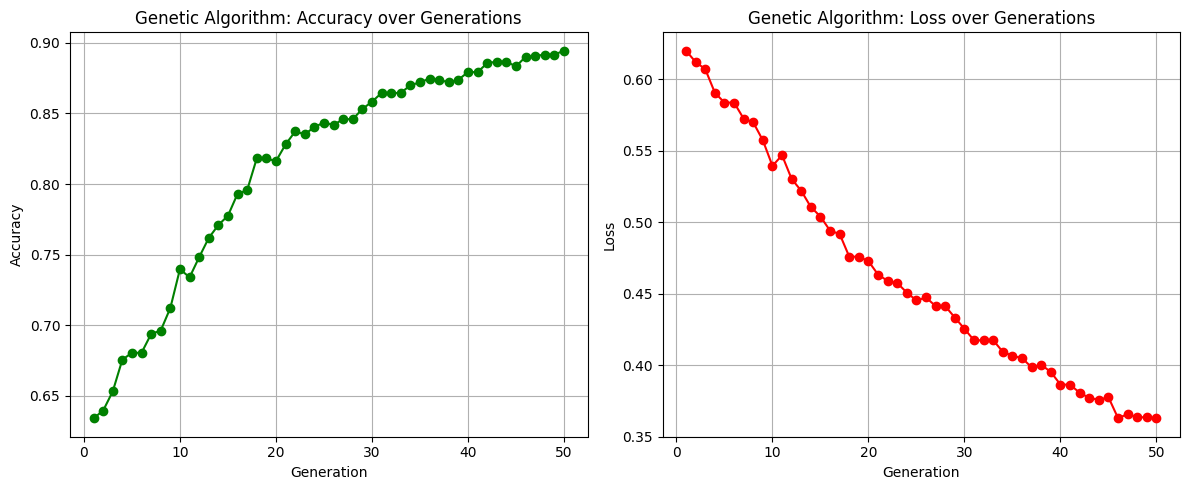

In [6]:
# === Accuracy & Loss Graph ===
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, len(ga.acc_progress) + 1), ga.acc_progress, marker='o', color='green')
plt.title("Genetic Algorithm: Accuracy over Generations")
plt.xlabel("Generation")
plt.ylabel("Accuracy")
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(range(1, len(ga.loss_progress) + 1), ga.loss_progress, marker='o', color='red')
plt.title("Genetic Algorithm: Loss over Generations")
plt.xlabel("Generation")
plt.ylabel("Loss")
plt.grid(True)

plt.tight_layout()
plt.show()